In [2]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from numba_stats import expon # crystalball,crystalball_ex, norm, expon, voigt, truncexpon

os.environ["HOMELUDO"] = '/home/submit/mori25/'
os.environ["DPLUDO"] = '/work/submit/mori25/Darkphotons_ludo/'

from training_offline import Trainer, plot_ROC,plot_ROC_train_test 

Start by looking at the performance of a few differend Y-trained BDTs. First evaluate them on the Y data and plot the ROC. 

In [3]:
Y_forest = Trainer("Y", 'forest_standard')
Y_forest.complete_load()
# Y_forest.plot_model()

Start loading data
Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Y/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Y.json
loading successful


Start loading data
Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Y/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/tree_standard_Y.json
loading successful


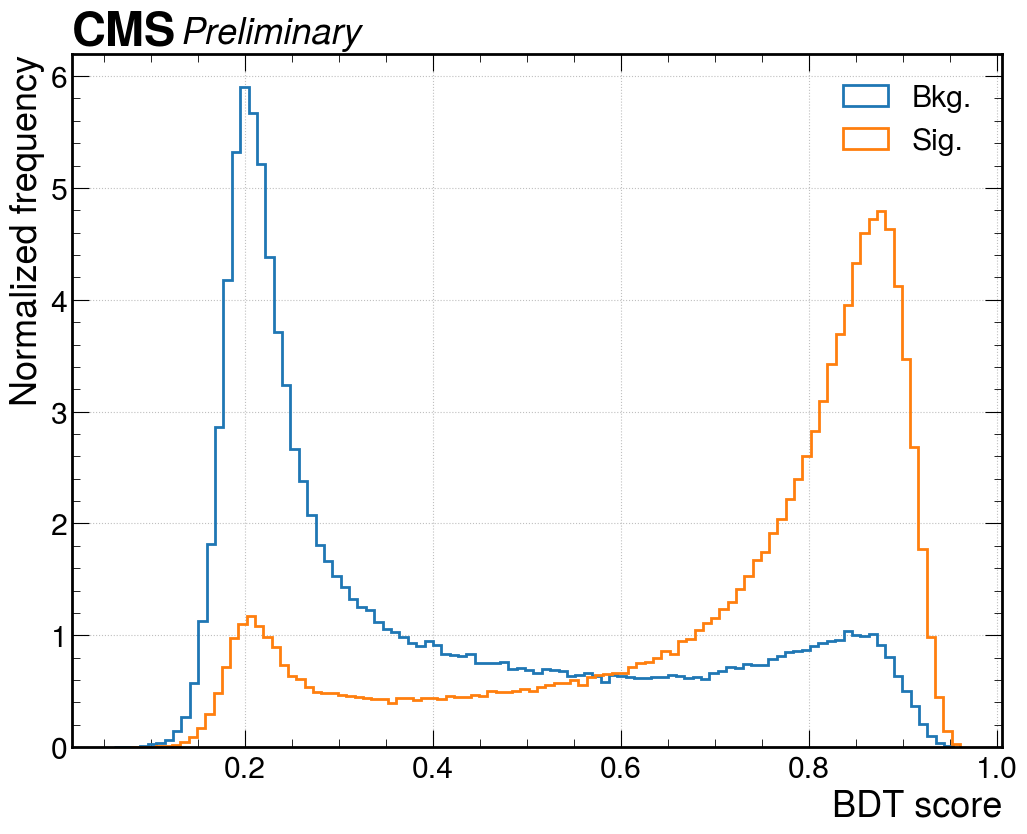

In [4]:
Y_tree = Trainer("Y", 'tree_standard')
Y_tree.complete_load()
Y_tree.plot_model()

In the next one we include the MuonID in the training sample. No significant improvements are noticeable in the ROCs. 

In [5]:
Y_forest_ID = Trainer("Y", 'forest_ID')
Y_forest_ID.complete_load()
# Y_forest_ID.plot_model()

Start loading data


Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Y/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_ID_Y.json
loading successful


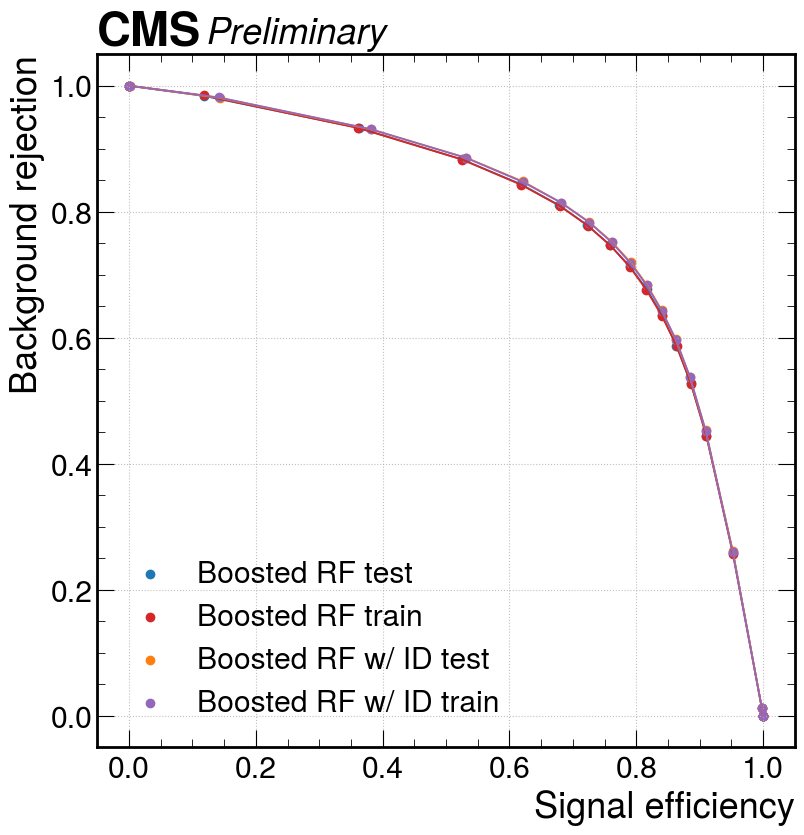

In [6]:
plot_ROC_train_test([Y_forest,Y_forest_ID], ["Boosted RF", "Boosted RF w/ ID"], n_points=20)

Now consider a special case: the Y-trained random forest evaluated on the Jpsi meson data. After computing the sPlots and unfolding signal and background, we will be able to apply corrections "ex post". However, here, we can still apply corrections based on the tail fit in the l_{xy} distribution, and define signal and background through the same cuts as in training (to be found in the config). We see how the prompt reweighing improves greatly the outcome.

In [7]:
Y_forest_on_Jpsi = Trainer("Y", 'forest_standard') #Trainer object accessing model trained on Y data
Y_forest_on_Jpsi.complete_load("Jpsi") #Load Jpsi data for evaluation
# Y_forest_on_Jpsi.plot_model(apply_weights=False)

Start loading data


Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Jpsi/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Y.json
loading successful


In [8]:
def nonPrompt_tail(x,N,b):
    return  N*expon.pdf(x,0,b)

Start loading data
Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Jpsi/merged_A.root:tree to memory
Start fitting function  <function nonPrompt_tail at 0x7f04f5cb1620> to variable  Mm_kin_lxy
Done fitting. Parameters:  5989.167444180199 0.1707232878448436

Some General infos:

                Total number of events considered: 2703328 

                Sum of weights: 1569606.9305717358 

                Fitted prompt: 1569521.2940682296

                Sum of weights>0 1577139.1635901472




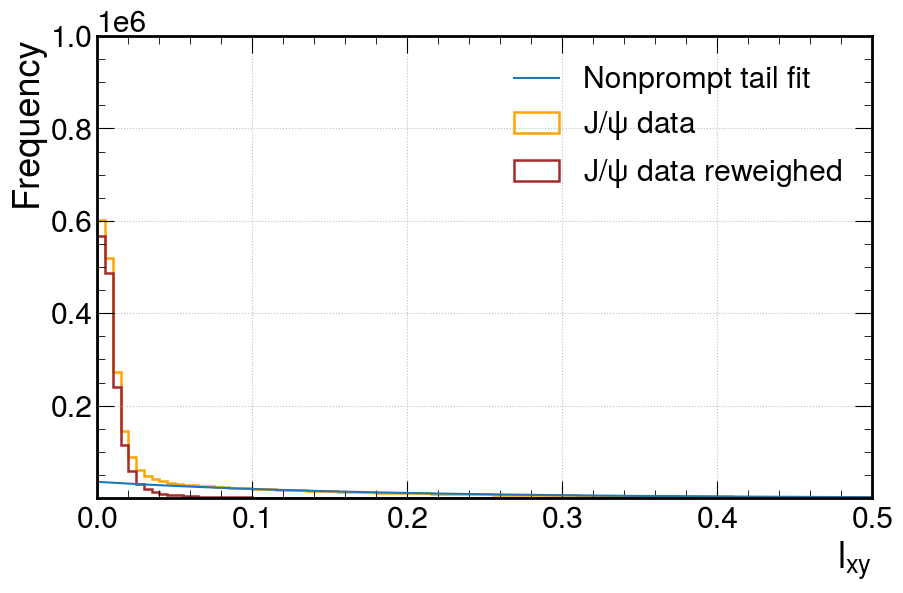

Total signal events: 331658
 Total signal weight: 211833.398104291, 0.87 of total weight
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Y.json
loading successful


In [9]:
modelname = "forest_standard"
Y_forest_on_Jpsi_corr = Trainer("Y", modelname)
Y_forest_on_Jpsi_corr.load_data("Jpsi")

#import reweighing parameters
lxy_cutoff = Y_forest_on_Jpsi_corr.particle_config["models"][modelname]["reweighing"]["lxy_cutoff"]
nbins_fit = Y_forest_on_Jpsi_corr.particle_config["models"][modelname]["reweighing"]["nbins_fit"]
nbins_corrections = Y_forest_on_Jpsi_corr.particle_config["models"][modelname]["reweighing"]["nbins_corrections"]

#Define data and compute weights
data_prompt = Y_forest_on_Jpsi_corr.full_mass_range[Y_forest_on_Jpsi_corr.full_mass_range["Mm_kin_lxy"]<lxy_cutoff]
weights_forest_standard = Y_forest_on_Jpsi_corr.compute_reweight(data_prompt,'Mm_kin_lxy', nonPrompt_tail,nbins_fit=nbins_fit,nbins_corrections=nbins_corrections,fit_range=(0.1,0.5),fitting_limits=[(0,1)],plot=True, xrange=(0,0.5))
weights_forest_standard = np.where(weights_forest_standard<0, 0, weights_forest_standard)


#Perform training and plot
Y_forest_on_Jpsi_corr.prepare_training_set(data_particle="Jpsi",data_override=data_prompt, weights=weights_forest_standard)
Y_forest_on_Jpsi_corr.load_model()
# Y_forest_on_Jpsi_corr.plot_model(apply_weights=True,density=True)

Start loading data


Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Jpsi/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Jpsi.json
loading successful


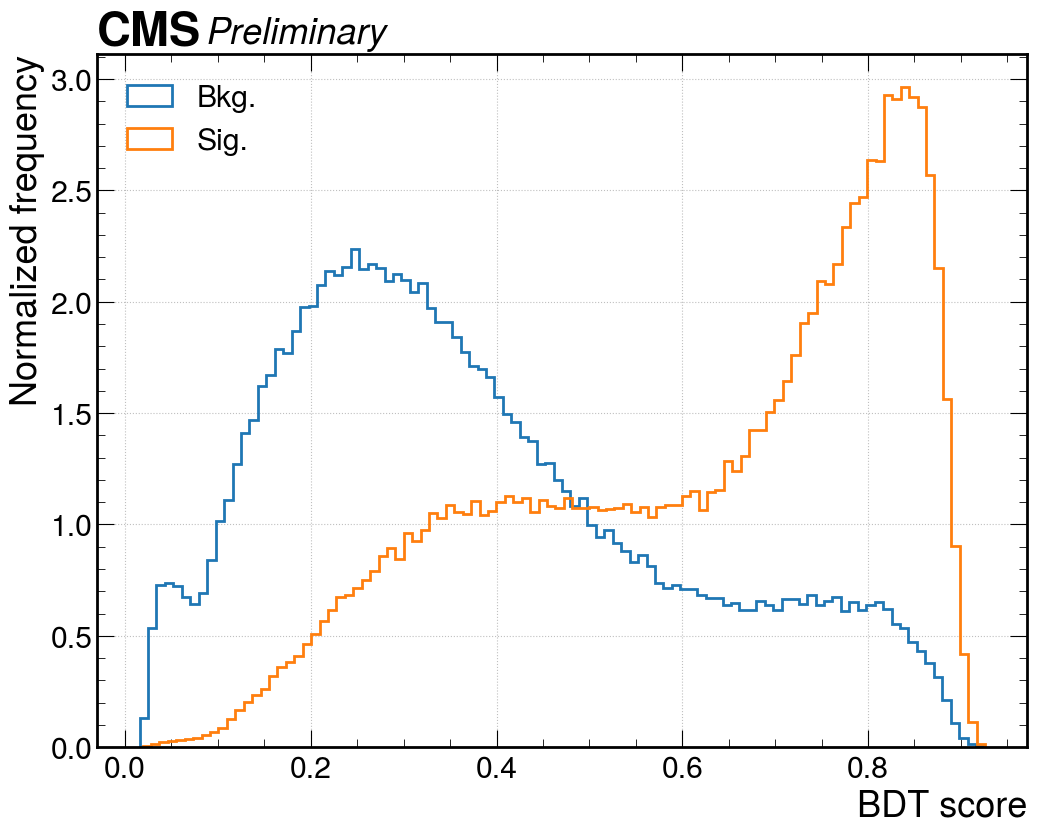

In [10]:
modelname = "forest_standard"
Jpsi_fs = Trainer("Jpsi", modelname)
Jpsi_fs.load_data()
Jpsi_fs.prepare_training_set()
Jpsi_fs.load_model()
Jpsi_fs.plot_model()

Start loading data


Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Jpsi/merged_A.root:tree to memory
Start fitting function  <function nonPrompt_tail at 0x7f04f5cb1620> to variable  Mm_kin_lxy
Done fitting. Parameters:  5989.167444180199 0.1707232878448436

Some General infos:

                Total number of events considered: 2703328 

                Sum of weights: 1569606.9305717358 

                Fitted prompt: 1569521.2940682296

                Sum of weights>0 1577139.1635901472




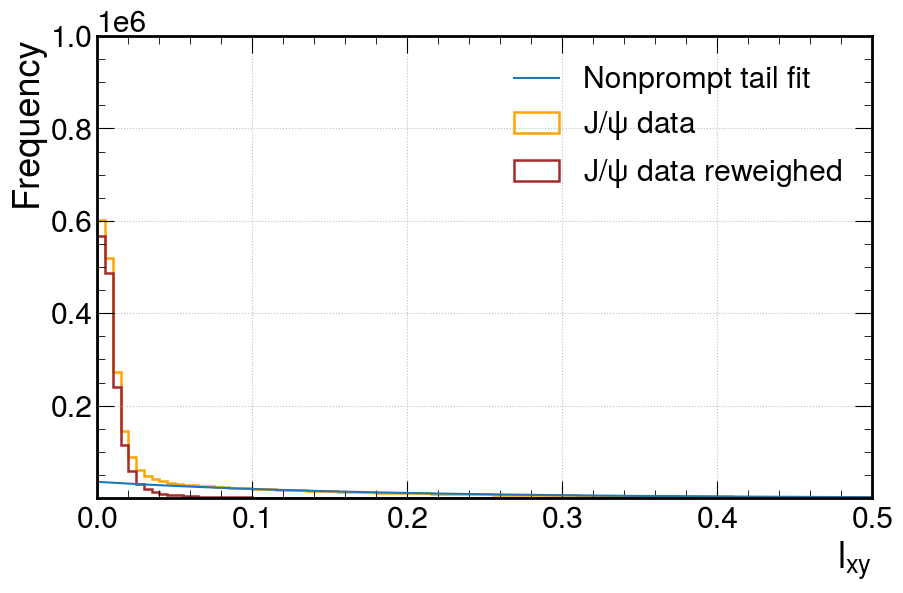

Total signal events: 331658
 Total signal weight: 211833.398104291, 0.87 of total weight
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_prompt_Jpsi.json
loading successful


In [11]:
modelname = "forest_prompt"
Jpsi_fp = Trainer("Jpsi", modelname)
Jpsi_fp.load_data()

#import reweighing parameters
lxy_cutoff = Jpsi_fp.particle_config["models"][modelname]["reweighing"]["lxy_cutoff"]
nbins_fit = Jpsi_fp.particle_config["models"][modelname]["reweighing"]["nbins_fit"]
nbins_corrections = Jpsi_fp.particle_config["models"][modelname]["reweighing"]["nbins_corrections"]

#Define data and compute weights
data_prompt = Jpsi_fp.full_mass_range[Jpsi_fp.full_mass_range["Mm_kin_lxy"]<lxy_cutoff]
weights_fp = Jpsi_fp.compute_reweight(data_prompt,'Mm_kin_lxy', nonPrompt_tail,nbins_fit=nbins_fit,nbins_corrections=nbins_corrections,fit_range=(0.1,0.5),fitting_limits=[(0,1)],plot=True, xrange = (0,0.5))
weights_fp = np.where(weights_fp<0, 0, weights_fp)

#Perform training and plot
Jpsi_fp.prepare_training_set(data_override=data_prompt, weights=weights_fp)
Jpsi_fp.load_model()
# Jpsi_fp.plot_model(apply_weights=True)

In [12]:
modelname = "forest_prompt_noPromptCut"
Jpsi_fp_nPC = Trainer("Jpsi", modelname)
Jpsi_fp_nPC.load_data()

#import reweighing parameters
lxy_cutoff = Jpsi_fp_nPC.particle_config["models"][modelname]["reweighing"]["lxy_cutoff"]
nbins_fit = Jpsi_fp_nPC.particle_config["models"][modelname]["reweighing"]["nbins_fit"]
nbins_corrections = Jpsi_fp_nPC.particle_config["models"][modelname]["reweighing"]["nbins_corrections"]

#Define data and compute weights
data_prompt = Jpsi_fp_nPC.full_mass_range[Jpsi_fp_nPC.full_mass_range["Mm_kin_lxy"]<lxy_cutoff]
weights_fp_nPC = Jpsi_fp_nPC.compute_reweight(data_prompt,'Mm_kin_lxy', nonPrompt_tail,nbins_fit=nbins_fit,nbins_corrections=nbins_corrections,fit_range=(0.1,0.5),fitting_limits=[(0,1)],plot=False)
weights_fp_nPC = np.where(weights_fp_nPC<0, 0, weights_fp_nPC)

#Perform training and plot
Jpsi_fp_nPC.prepare_training_set(data_override=data_prompt,weights=weights_fp_nPC)
Jpsi_fp_nPC.load_model()
# Jpsi_fp_nPC.plot_model(apply_weights=True)

Start loading data
Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Jpsi/merged_A.root:tree to memory
Start fitting function  <function nonPrompt_tail at 0x7f04f5cb1620> to variable  Mm_kin_lxy
Done fitting. Parameters:  11836.07442957287 0.170668355157349


/work/submit/mori25/Darkphotons_ludo/BDT/training_offline.py:175: RuntimeWarning: divide by zero encountered in divide
  weight_hist = np.where(histSlxy==0,0, (histSlxy-fitting_func(x_corr,*mData.values)/dx_fit*dx_corr)/histSlxy)



Some General infos:

                Total number of events considered: 2803054 

                Sum of weights: 1604368.1913661 

                Fitted prompt: 1604154.9418350817

                Sum of weights>0 1611955.9816561572


Total signal events: 340193
 Total signal weight: 214345.60032103362, 0.86 of total weight
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_prompt_noPromptCut_Jpsi.json
loading successful


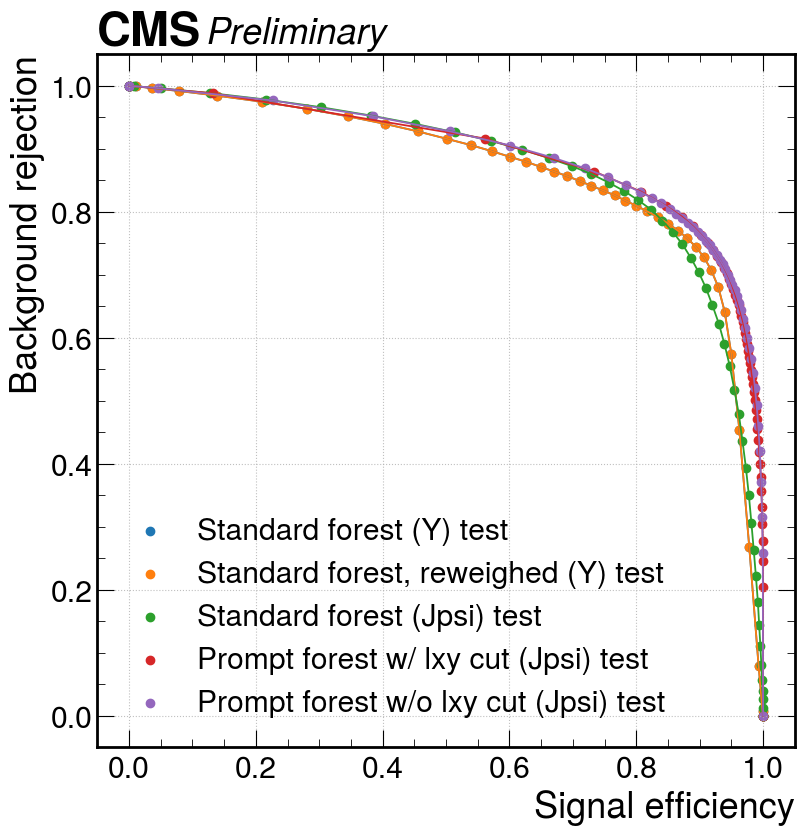

In [13]:
plot_ROC([Y_forest_on_Jpsi,Y_forest_on_Jpsi_corr, Jpsi_fs,Jpsi_fp,Jpsi_fp_nPC], 
         ["Standard forest (Y)", "Standard forest, reweighed (Y)","Standard forest (Jpsi)", "Prompt forest w/ lxy cut (Jpsi)", "Prompt forest w/o lxy cut (Jpsi)"],
         [Jpsi_fp_nPC.dval,Jpsi_fp_nPC.dval,Jpsi_fp_nPC.dval,Jpsi_fp_nPC.dval,Jpsi_fp_nPC.dval],n_points=50)

In [14]:
Jpsi_forest_on_Y = Trainer("Jpsi", 'forest_prompt') #Trainer object accessing model trained on Y data
Jpsi_forest_on_Y.complete_load("Y") #Load Jpsi data for evaluation
# Jpsi_forest_on_Y.plot_model(apply_weights=False)

Start loading data


Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Y/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_prompt_Jpsi.json
loading successful


In [15]:
Jpsi_forest_on_Y = Trainer("Jpsi", 'forest_standard') #Trainer object accessing model trained on Y data
Jpsi_forest_on_Y.complete_load("Y") #Load Jpsi data for evaluation
# Jpsi_forest_on_Y.plot_model(apply_weights=False)

Start loading data
Successfully imported data file /data/submit/mori25/dark_photons_ludo/DimuonTrees/offline/Y/merged_A.root:tree to memory
Defined training and evaluation datasets

loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Jpsi.json
loading successful


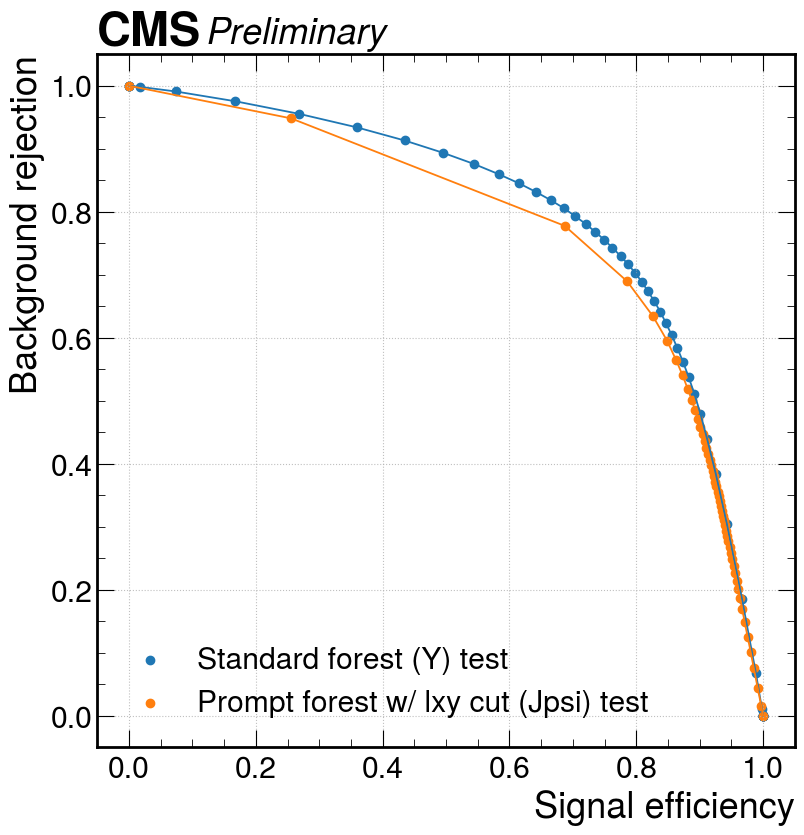

In [16]:
plot_ROC([Y_forest_on_Jpsi_corr ,Jpsi_fp], 
         [ "Standard forest (Y)","Prompt forest w/ lxy cut (Jpsi)"],
         [Y_forest.dval,Y_forest.dval],n_points=50)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

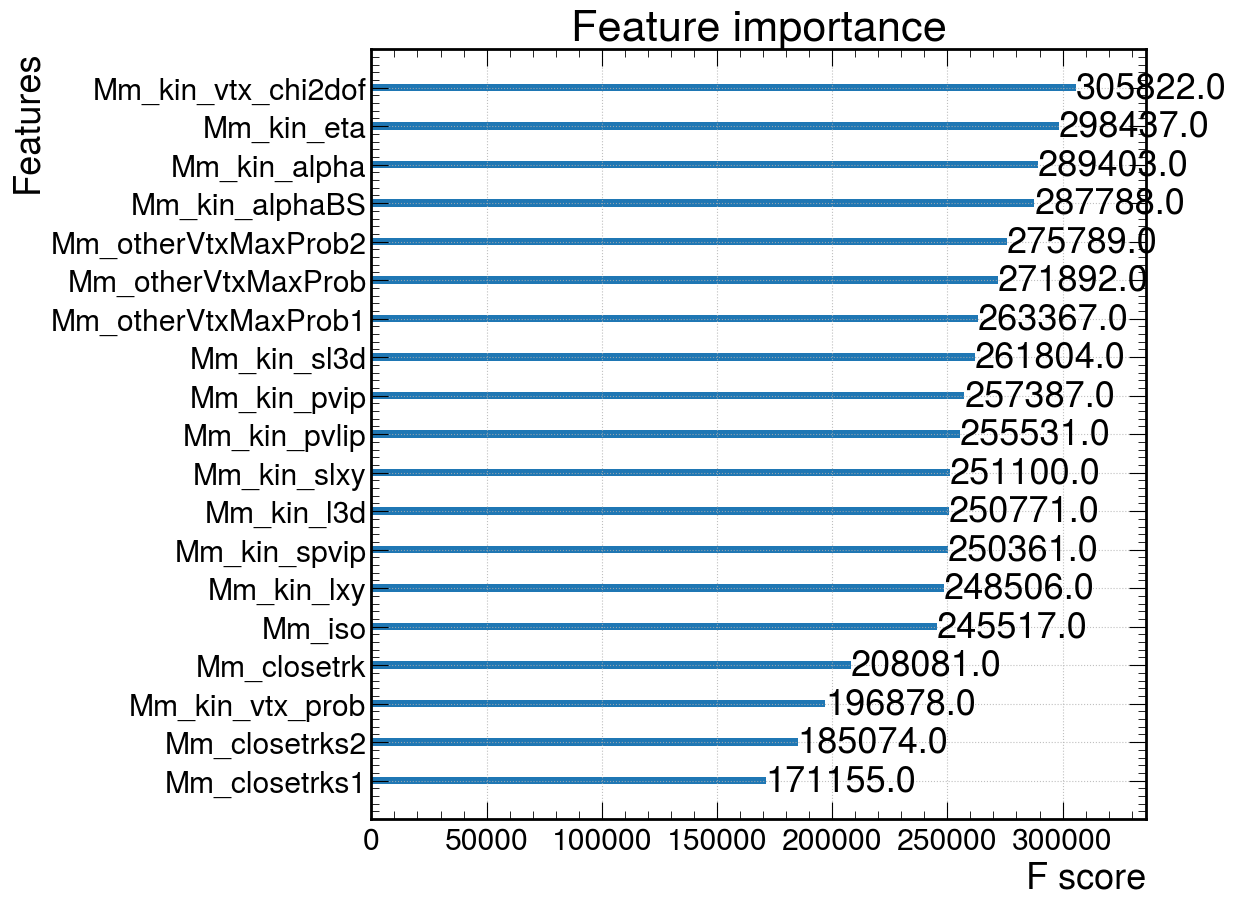

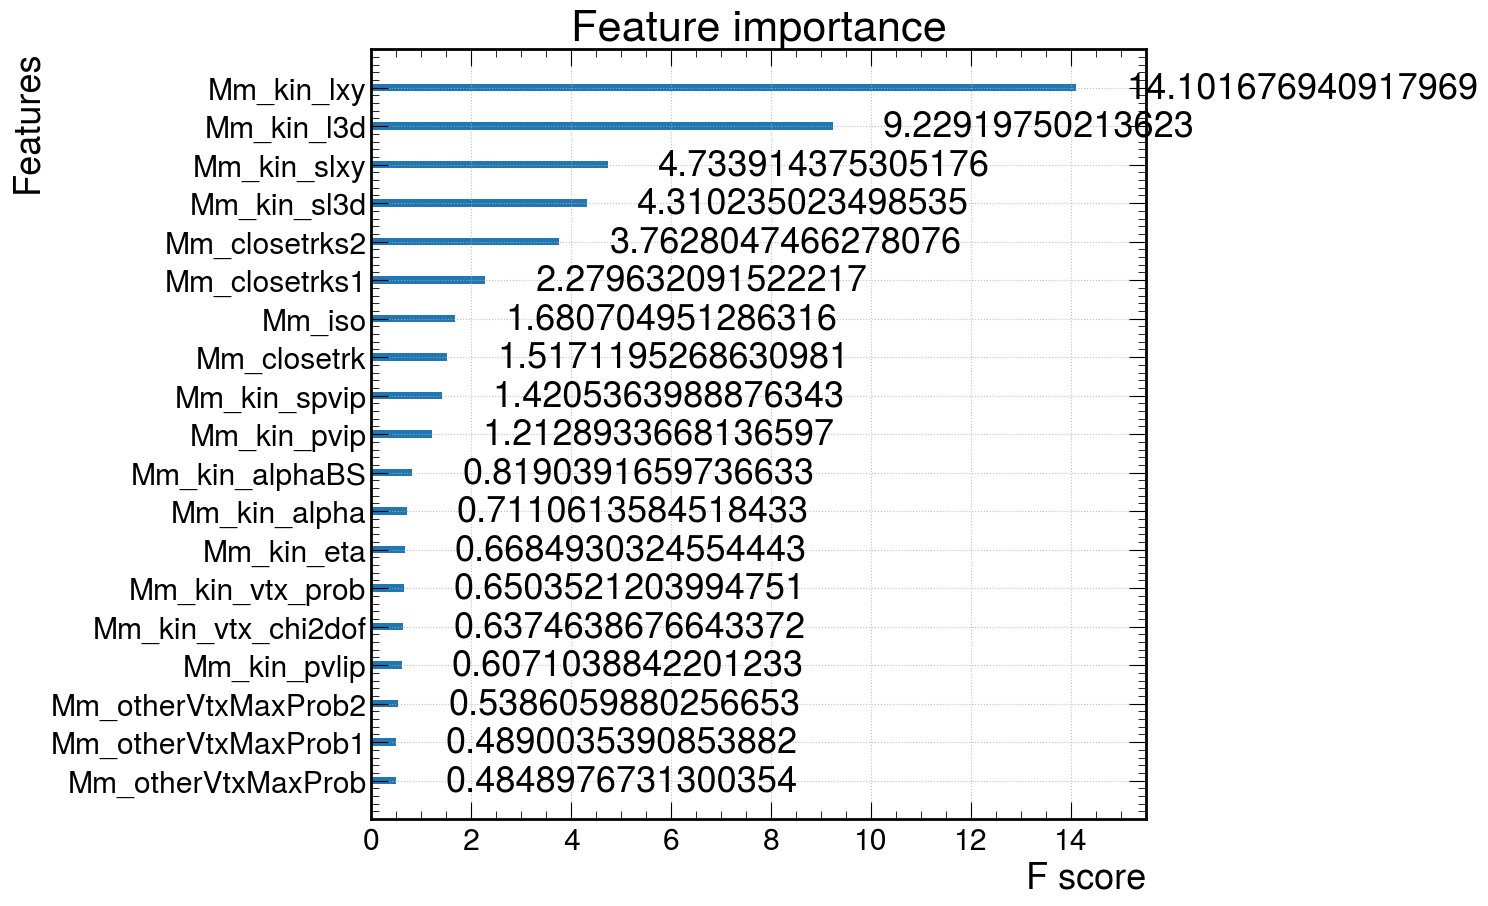

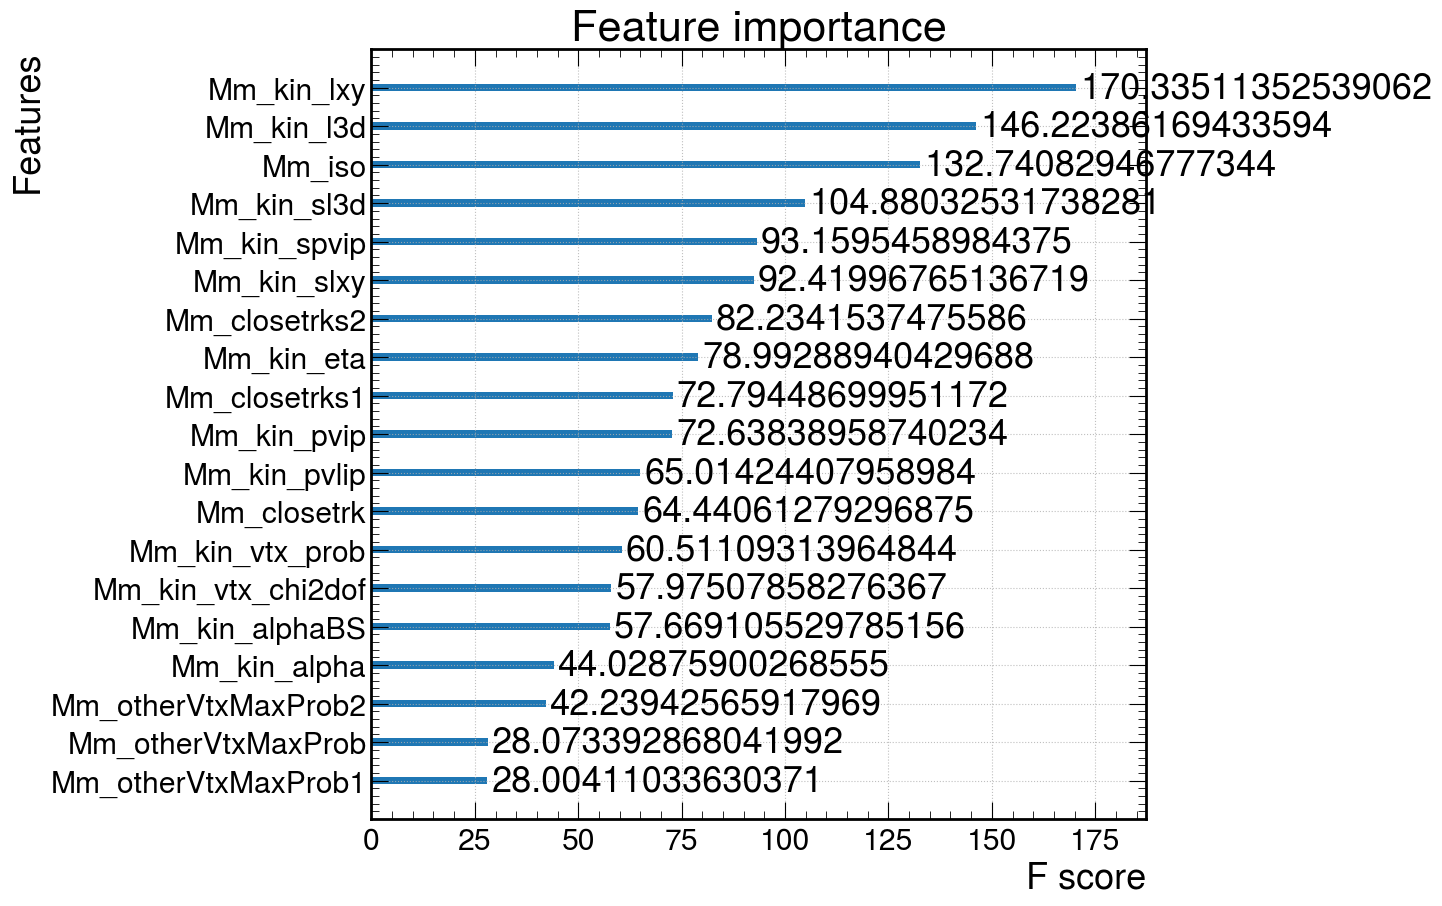

In [21]:
# xgb.plot_tree(Jpsi_fp.bst)
xgb.plot_importance(Jpsi_fp.bst, importance_type='weight')
xgb.plot_importance(Jpsi_fp.bst, importance_type='gain')
xgb.plot_importance(Jpsi_fp.bst, importance_type='cover')

In [ ]:
print(len(Jpsi_fp.full_mass_range["Mm_kin_lxy"]), len(weights_fp))
print(len(Jpsi_fp_nPC.full_mass_range), len(weights_fp_nPC))

2703166 2703166
2803060 2803060


In [22]:
# Jpsi_fp_nPC.plot_hist([Jpsi_fp_nPC.X_val["Mm_kin_lxy"][Jpsi_fp_nPC.y_val==1],
#                        Jpsi_fp_nPC.X_val["Mm_kin_lxy"][Jpsi_fp_nPC.y_val==0],
#                        Jpsi_fs.X_val["Mm_kin_lxy"][Jpsi_fs.y_val==1],
#                        Jpsi_fs.X_val["Mm_kin_lxy"][Jpsi_fs.y_val==0],
#                        Jpsi_fp_nPC.full_mass_range["Mm_kin_lxy"],
#                        ],
#                     ["Signal rew.","Background rew.","Signal","Background",'data rew'], 
#                     weights=[weights_fp_nPC[Jpsi_fp_nPC.X_val.index][Jpsi_fp_nPC.y_val==1],weights_fp_nPC[Jpsi_fp_nPC.X_val.index][Jpsi_fp_nPC.y_val==0],None,None,weights_fp_nPC], xlim=(0,5), xlabel = "lxy", log=True,density=True)

# Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_lxy"][Jpsi_fp.y_val==1][(Jpsi_fp.val_sig>0.32) & (Jpsi_fp.val_sig<0.42) ],
#                    Jpsi_fp.X_val["Mm_kin_lxy"][Jpsi_fp.y_val==1][(Jpsi_fp.val_sig>0.8) ],
#                    Jpsi_fp.X_val["Mm_kin_lxy"][Jpsi_fp.y_val==0],
                       
#                        ],
#                     ["Bkg-like Signal rew. ","Sig-like Signal rew.","Background"], 
#                     weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1][(Jpsi_fp.val_sig>0.32) & (Jpsi_fp.val_sig<0.42) ],
#                              weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1][(Jpsi_fp.val_sig>0.8) ],
#                              weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0]], xlim=(0,1), xlabel = "lxy", log=False,density=False)

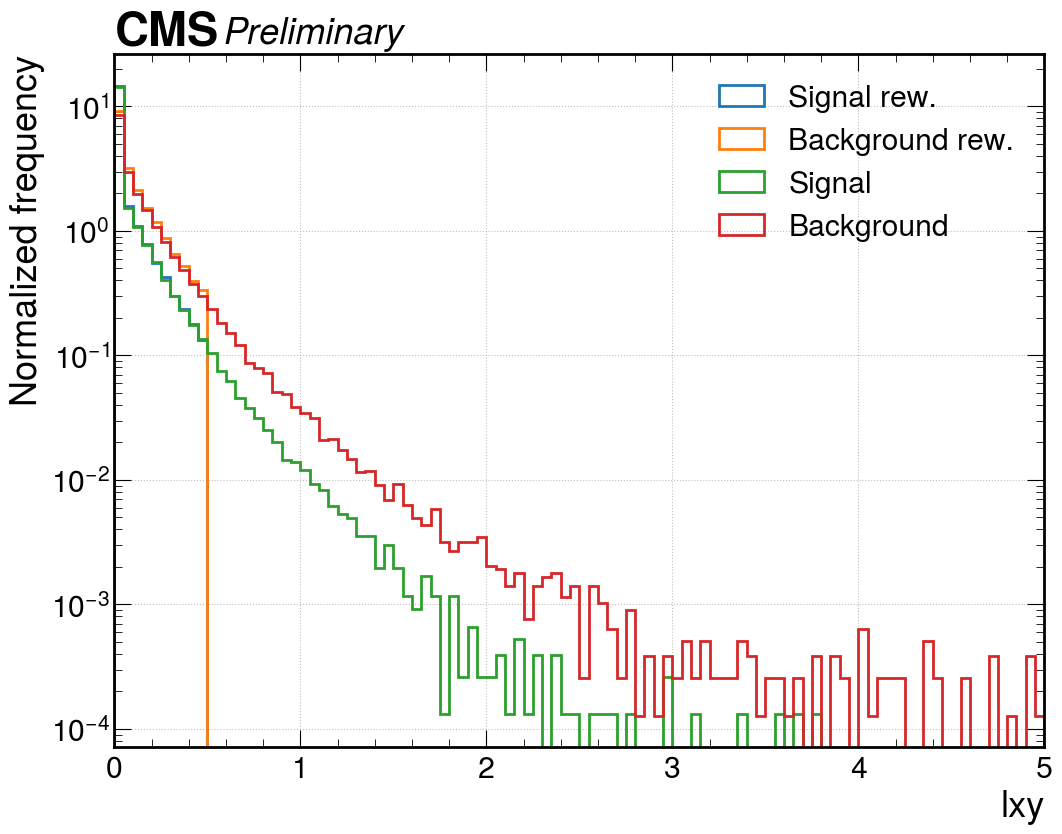

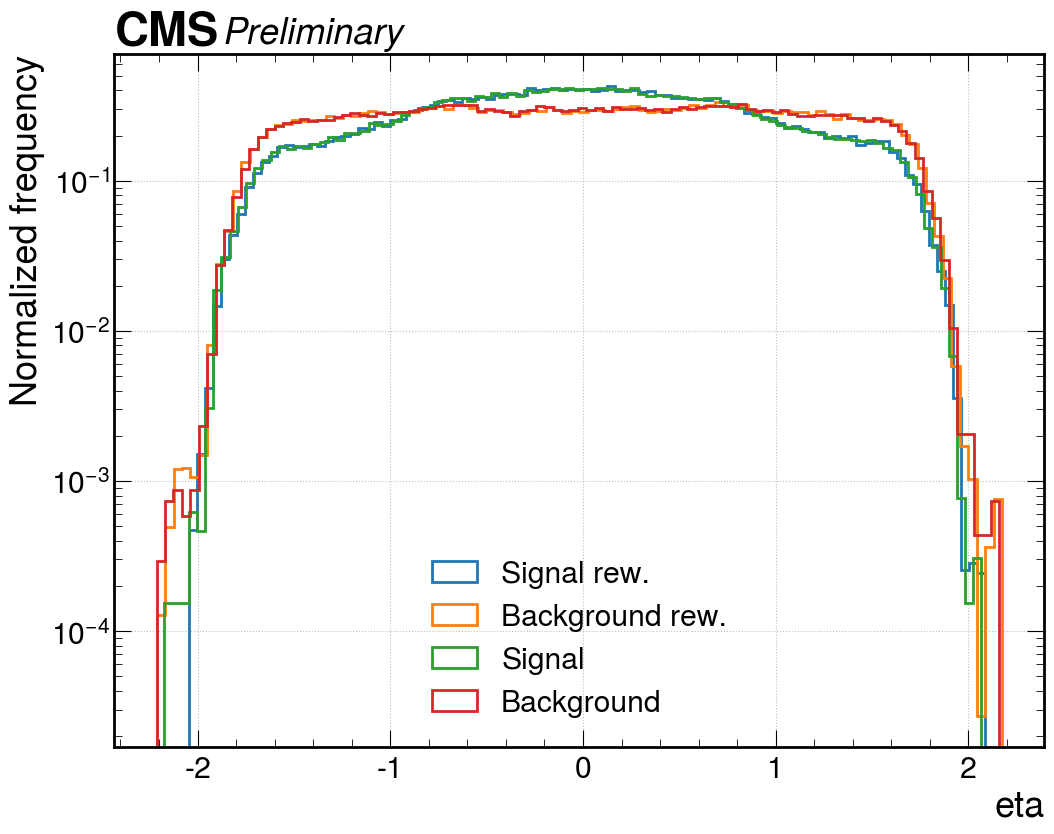

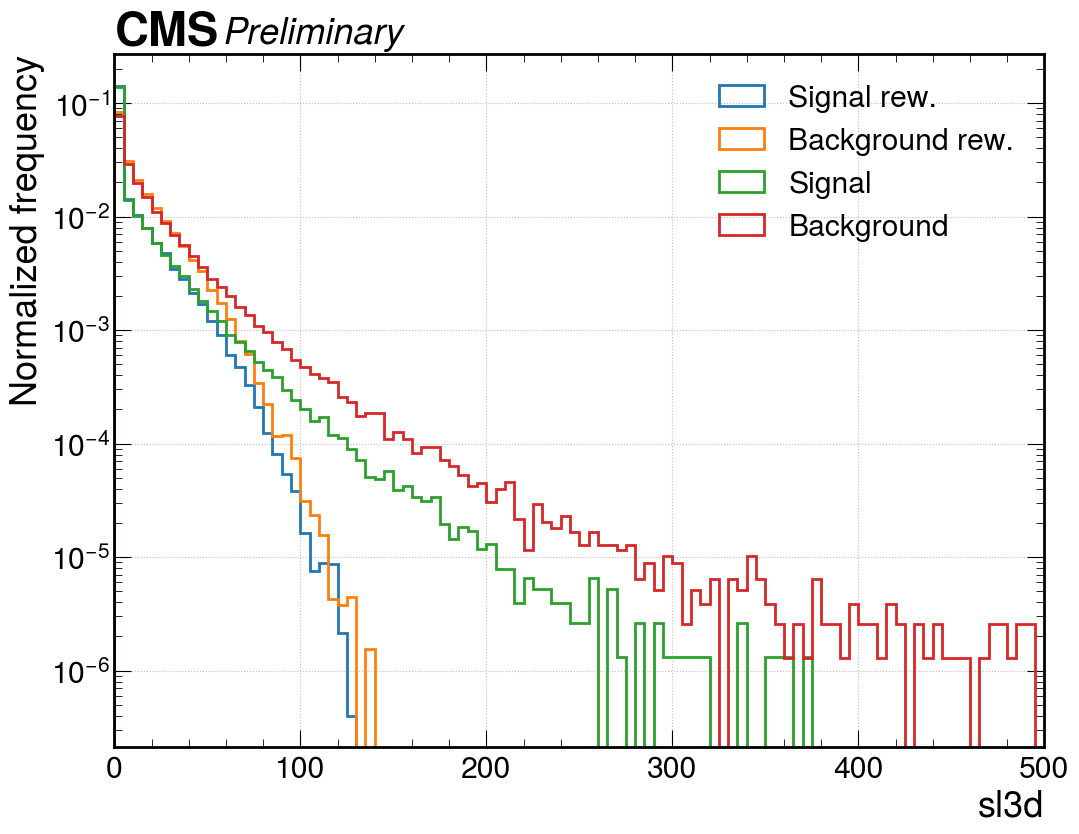

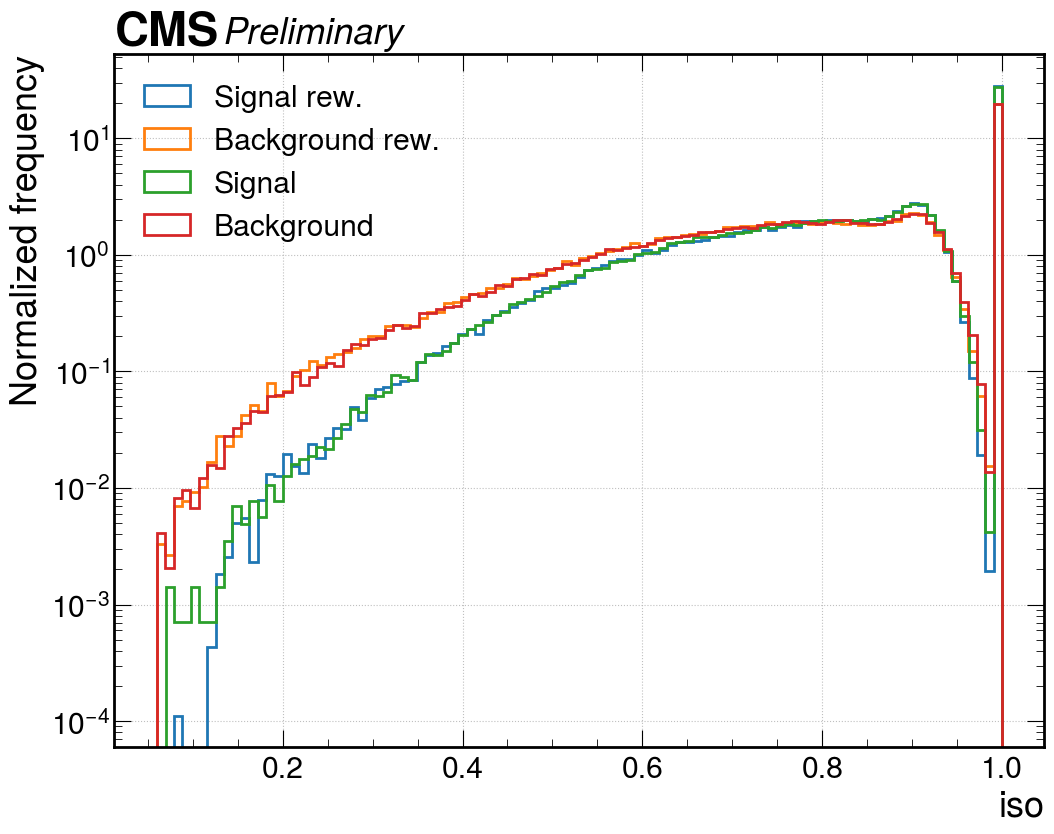

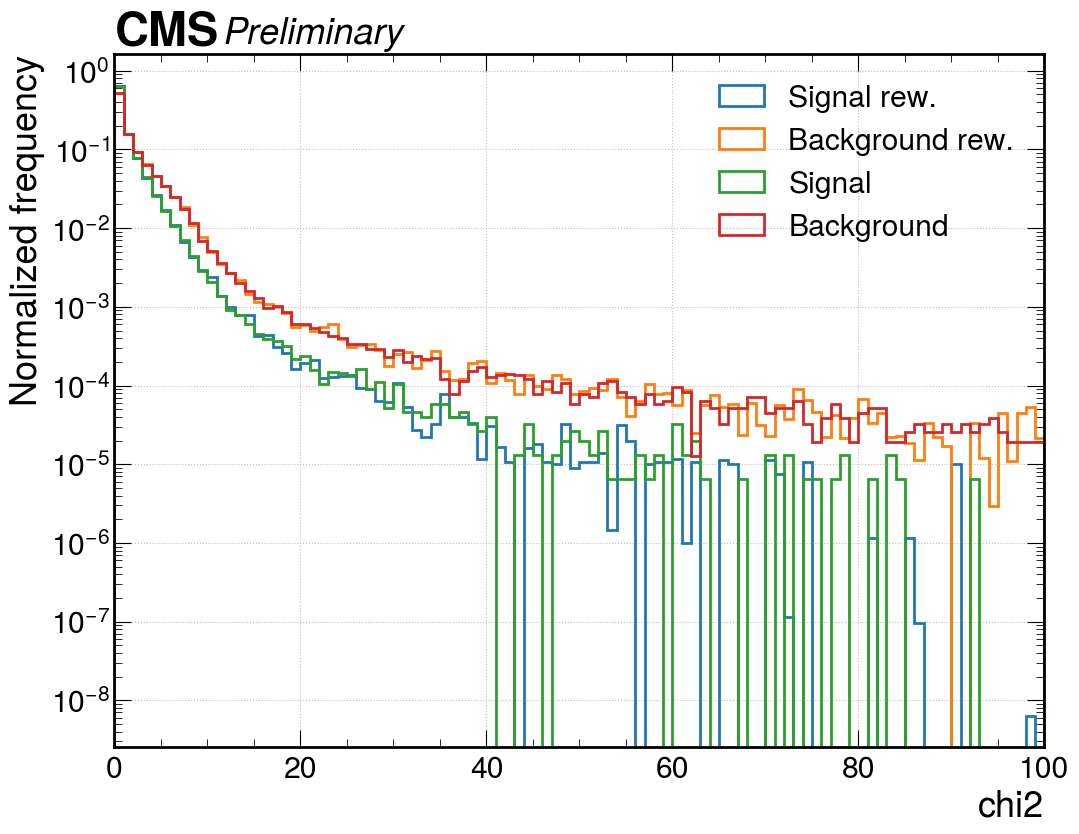

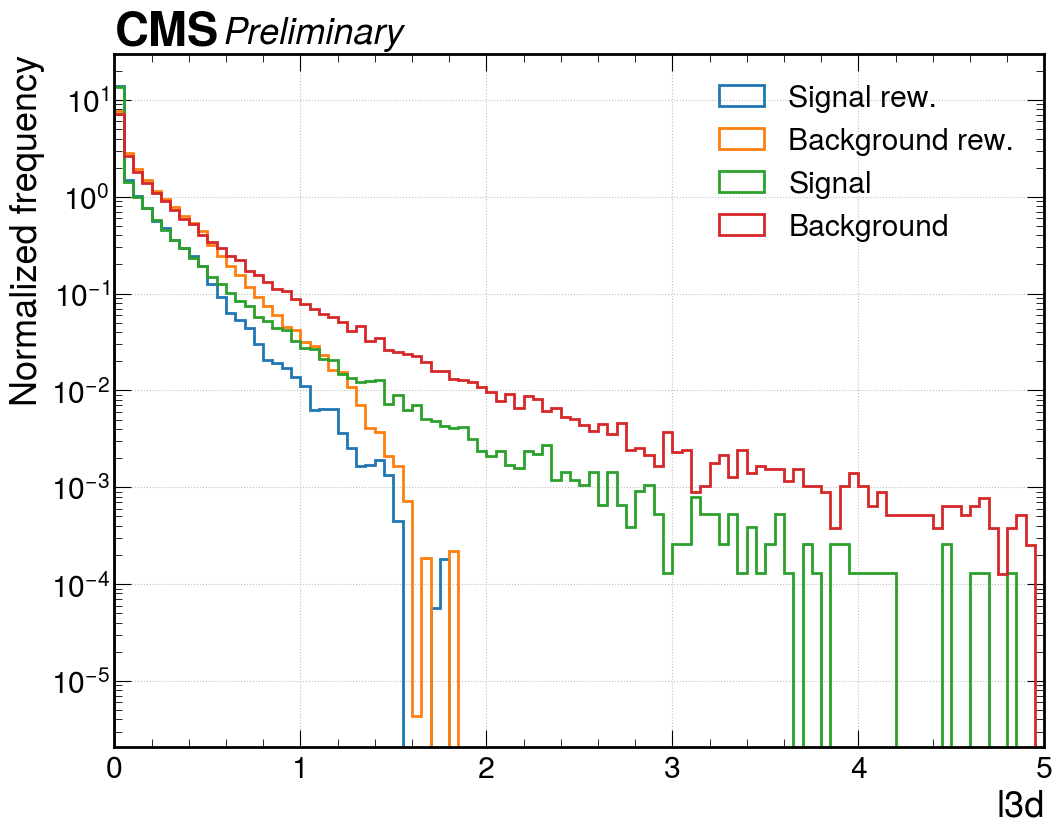

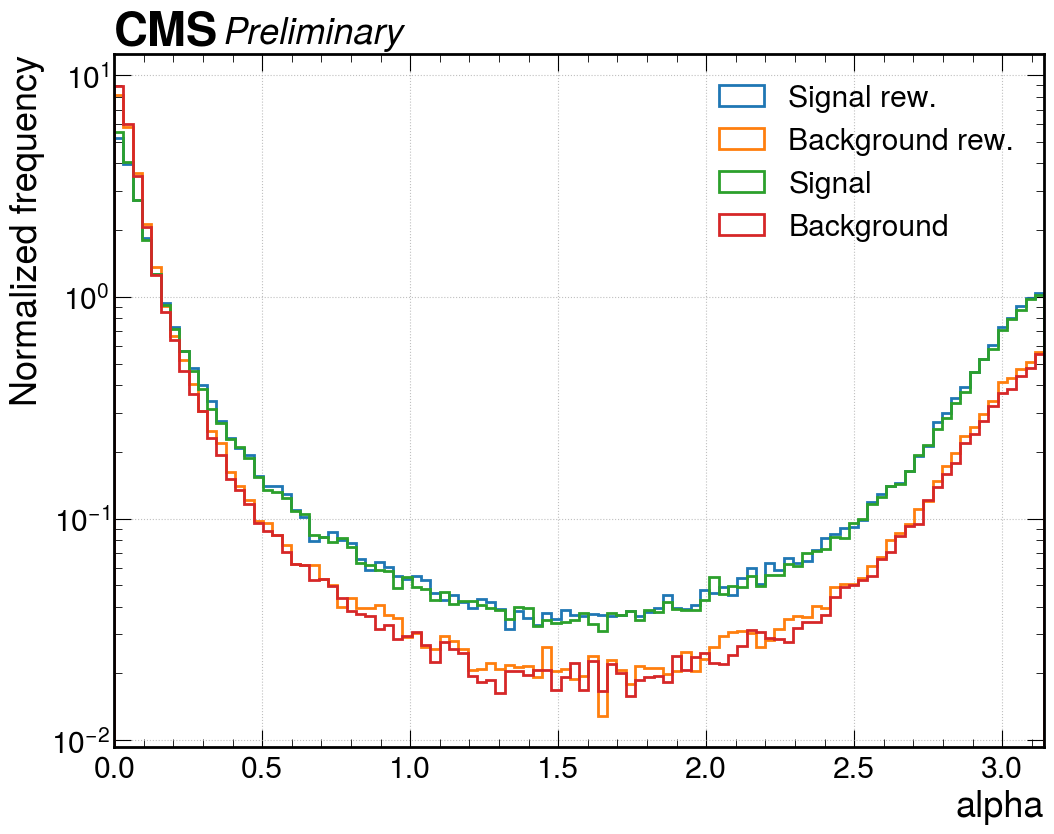

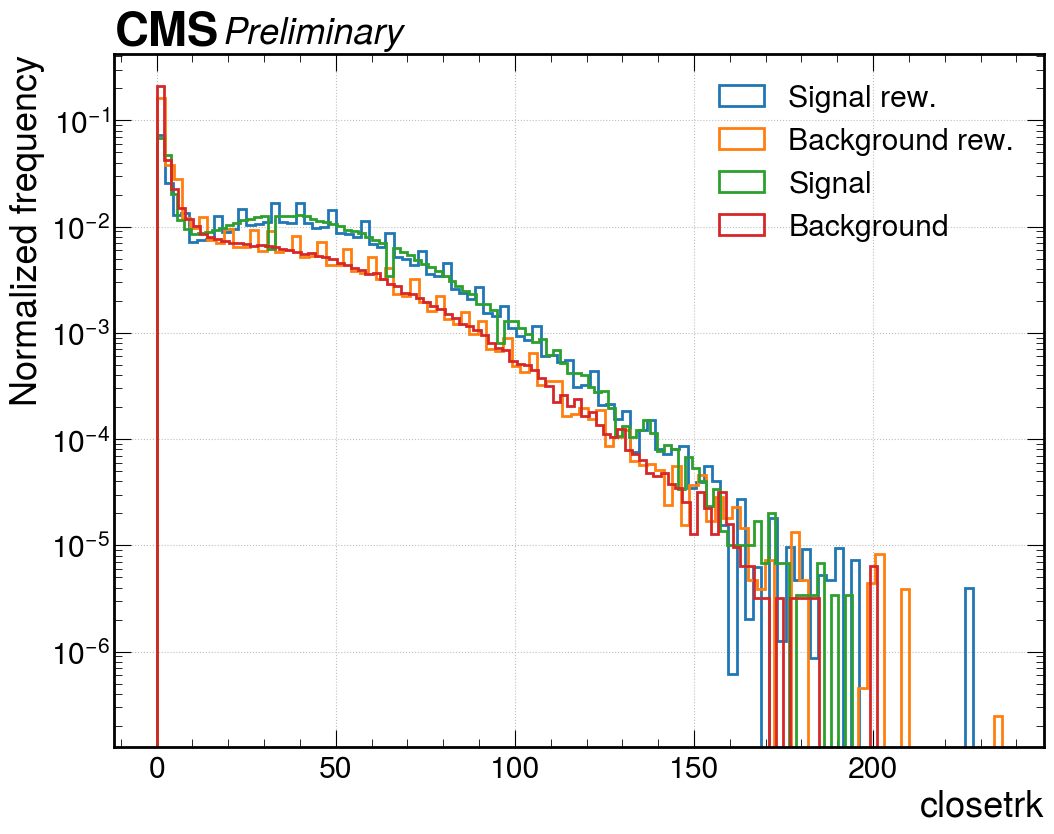

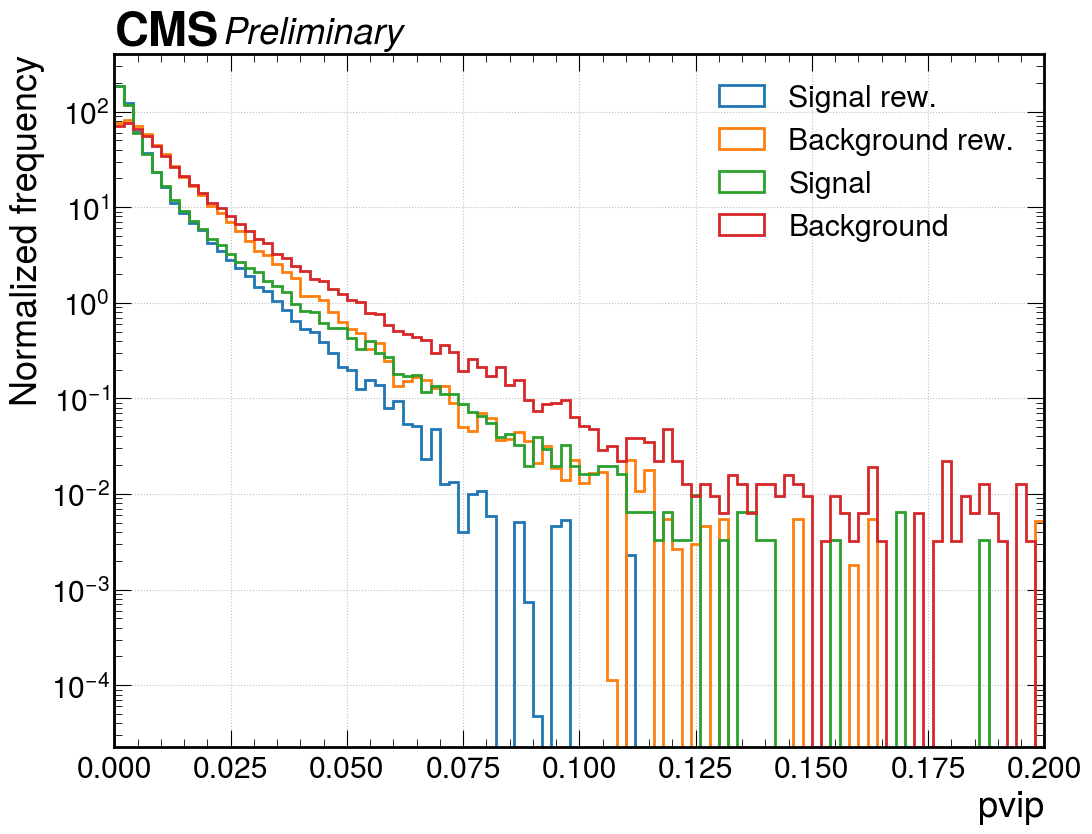

In [23]:
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_lxy"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_lxy"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_lxy"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_lxy"][Jpsi_fs.y_val==0]],
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None], xlim=(0,5), xlabel = "lxy", log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_eta"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_eta"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_eta"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_eta"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None],  xlabel="eta", log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_sl3d"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_sl3d"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_sl3d"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_sl3d"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None],  xlim=(0,500), xlabel = 'sl3d', log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_iso"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_iso"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_iso"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_iso"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None], xlabel = 'iso', log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_vtx_chi2dof"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_vtx_chi2dof"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_vtx_chi2dof"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_vtx_chi2dof"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None],  xlabel = 'chi2', xlim = (0,100), log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_l3d"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_l3d"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_l3d"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_l3d"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None], xlabel='l3d', xlim=(0,5), log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_alpha"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_alpha"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_alpha"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_alpha"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None],  xlabel='alpha',xlim=(0,3.142), log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_closetrk"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_closetrk"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_closetrk"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_closetrk"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None], xlabel='closetrk', log=True,density=True)
Jpsi_fp.plot_hist([Jpsi_fp.X_val["Mm_kin_pvip"][Jpsi_fp.y_val==1],
                       Jpsi_fp.X_val["Mm_kin_pvip"][Jpsi_fp.y_val==0],
                       Jpsi_fs.X_val["Mm_kin_pvip"][Jpsi_fs.y_val==1],
                       Jpsi_fs.X_val["Mm_kin_pvip"][Jpsi_fs.y_val==0]], 
                    ["Signal rew.","Background rew.","Signal","Background"], 
                    weights=[weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==1],weights_fp[Jpsi_fp.X_val.index][Jpsi_fp.y_val==0],None,None], xlabel='pvip', xlim=(0,0.2), log=True,density=True)

Now look for optimal discriminators

In [24]:
predY = Y_forest.bst.predict(xgb.DMatrix(Y_forest.trainData_skinny))
predJpsi = Y_forest.bst.predict(xgb.DMatrix(Y_forest_on_Jpsi.trainData_skinny))

In [25]:
#Study cuts on discriminators to optimize for Y

id1Y=Y_tree.trainData["Muon_softMva1"]
id2Y=Y_tree.trainData["Muon_softMva2"]
sig_cut = Y_tree.trainData["Score"]==1
bkg_cut = Y_tree.trainData["Score"]==0

def efficiencyY(id_lim,dis_lim):
    sig = (predY[sig_cut] > dis_lim) & (id1Y[sig_cut] > id_lim) & (id2Y[sig_cut] > id_lim)
    s = np.sum(sig)
    bkg = (predY[bkg_cut] > dis_lim) & (id1Y[bkg_cut] > id_lim) & (id2Y[bkg_cut] > id_lim)
    b = np.sum(bkg)
    return s/np.sqrt(b) if b!= 0 else 0



In [26]:
id_vals = np.linspace(0.2,0.5,50)
vtx_vals= np.linspace(0.45,0.9,50)
XY, YY = np.meshgrid(id_vals,vtx_vals)
effY = np.vectorize(efficiencyY)(XY,YY)
idxY = np.unravel_index(np.argmax(effY),effY.shape)
print("Optimal discriminator cuts: \n SoftMVA (Muon ID): ", XY[idxY], "\n BDT (Vertex quantities): ", YY[idxY])

Optimal discriminator cuts: 
 SoftMVA (Muon ID):  0.45102040816326533 
 BDT (Vertex quantities):  0.7163265306122449


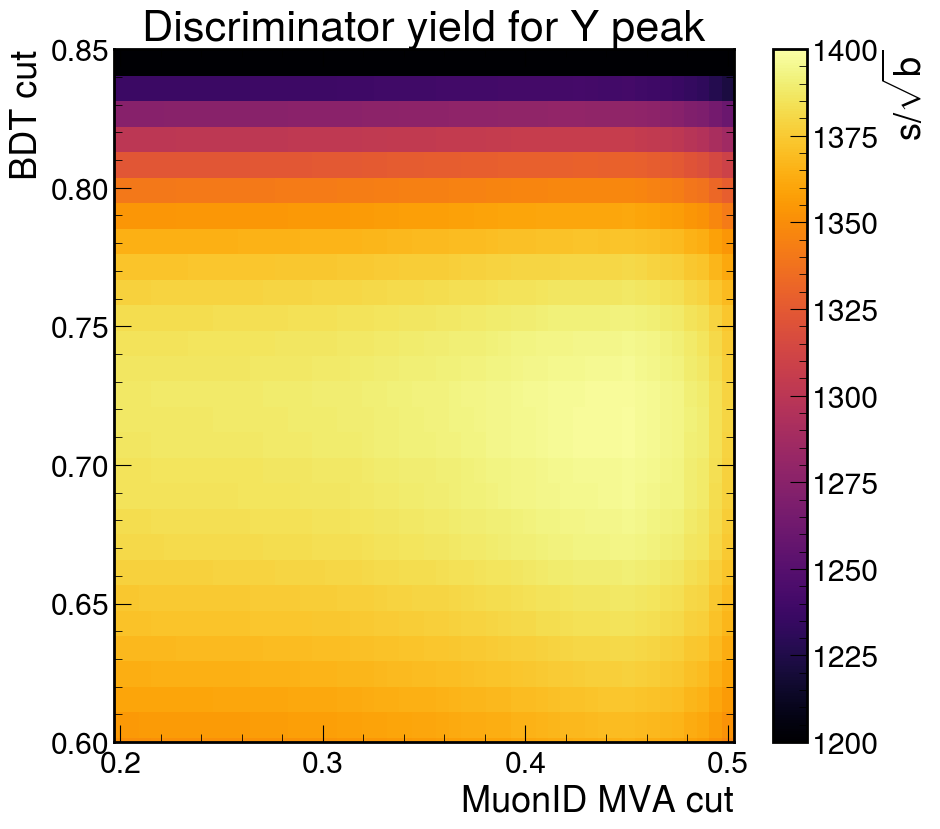

In [27]:
plt.figure(figsize=(10, 9))
pcm = plt.pcolormesh(XY, YY, effY, shading='auto', cmap='inferno',vmin=1200,vmax=1400)# norm=matplotlib.colors.LogNorm()
colorbar = plt.colorbar(pcm, label='$s/\sqrt{b}$')
# colorbar_ticks = [1000,1300 , 2000]  # Define your desired tick positions
# colorbar.set_ticks(colorbar_ticks)
plt.xlabel('MuonID MVA cut')
plt.ylabel('BDT cut')
plt.title('Discriminator yield for Y peak')
plt.ylim(0.6,0.85)
plt.show()

In [28]:
id1Jpsi=Y_forest_on_Jpsi.trainData["Muon_softMva1"]
id2Jpsi=Y_forest_on_Jpsi.trainData["Muon_softMva2"]
sig_cut = Y_forest_on_Jpsi.trainData["Score"]==1
bkg_cut = Y_forest_on_Jpsi.trainData["Score"]==0

def efficiencyJpsi(id_lim,dis_lim):
    sig = (predJpsi[sig_cut] > dis_lim) & (id1Jpsi[sig_cut] > id_lim) & (id2Jpsi[sig_cut] > id_lim)
    s = np.sum(sig)
    bkg = (predJpsi[bkg_cut] > dis_lim) & (id1Jpsi[bkg_cut] > id_lim) & (id2Jpsi[bkg_cut] > id_lim)
    b = np.sum(bkg)
    return s/np.sqrt(b) if b!= 0 else 0

In [29]:
id_vals = np.linspace(0.2,0.5,50)
vtx_vals= np.linspace(0.2,0.8,50)
XY, YY = np.meshgrid(id_vals,vtx_vals)
effJpsi = np.vectorize(efficiencyJpsi)(XY,YY)
idxJpsi = np.unravel_index(np.argmax(effJpsi),effJpsi.shape)
print("Optimal discriminator cuts on Jpsi: \n SoftMVA (Muon ID): ", XY[idxJpsi], "\n BDT (Vertex quantities): ", YY[idxJpsi])

Optimal discriminator cuts on Jpsi: 
 SoftMVA (Muon ID):  0.39591836734693875 
 BDT (Vertex quantities):  0.4448979591836735


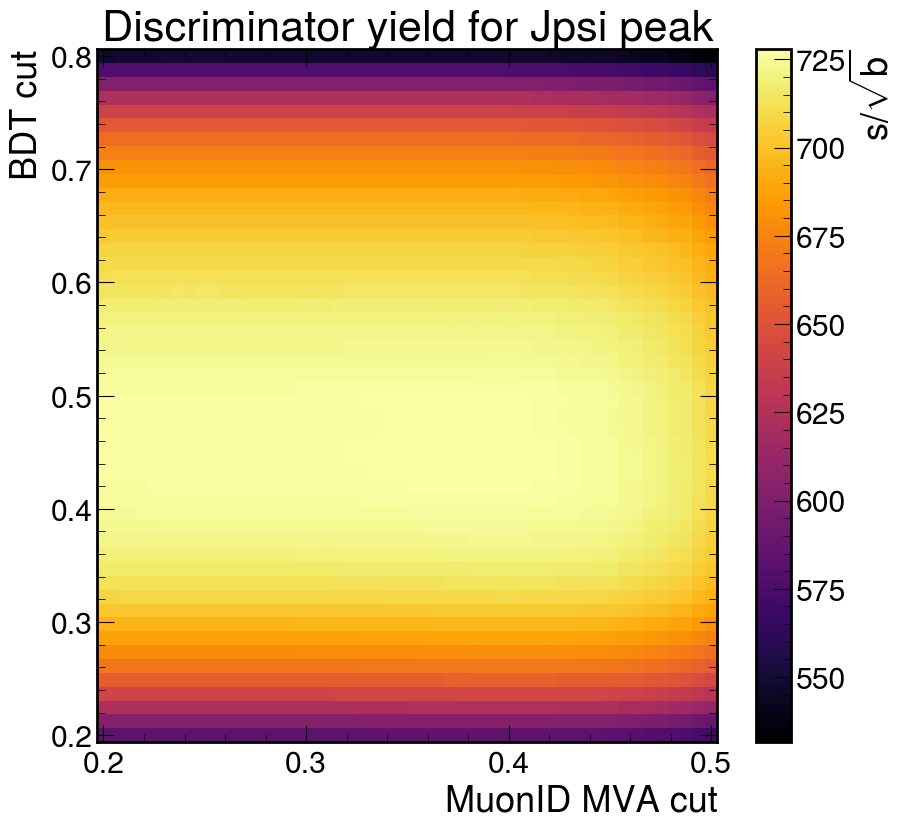

In [30]:
plt.figure(figsize=(10, 9))
pcm = plt.pcolormesh(XY, YY, effJpsi, shading='auto', cmap='inferno')# norm=matplotlib.colors.LogNorm()
colorbar = plt.colorbar(pcm, label='$s/\sqrt{b}$')
# colorbar_ticks = [1000,1300 , 2000]  # Define your desired tick positions
# colorbar.set_ticks(colorbar_ticks)
plt.xlabel('MuonID MVA cut')
plt.ylabel('BDT cut')
plt.title('Discriminator yield for Jpsi peak')
# plt.ylim(0.6,0.85)
plt.show()